**These days when a new movie is being released, it isn't a question of IF it will be released in another country, but rather HOW MANY other countries? The question we aim to analyze for Microsoft Entertainment Studios is:**

**Are movies that are released in more countries more profitable?**

**The findings in this notebook will show that the answer to that question is in fact: yes. This notebook will walk step-by-step through the importing, cleaning, exploration, and visualization processes undertaken to try and answer Microsoft's question and help inform strategic business decisions going forward.**

**The data being analyzed are from two sources: IMDB country data per movie and Box Office Mojo revenue and budget information. These datasets have been saved into an SQL database previously and will be imported into this notebook further down.**

# Import packages and set SQL cursor

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import os
%matplotlib inline

conn = sqlite3.connect('movies_db.sqlite')
cur = conn.cursor()

## Adjust view space

In [72]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Bring in data from our SQL database

## Creating our Countries per Movie DataFrame

In [73]:
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [74]:
cur.execute('''SELECT primary_title, region
                FROM imdb_title_akas a
                JOIN imdb_title_basics b
                ON a.title_id = b.tconst
                ;''')
df_title_region = pd.DataFrame(cur.fetchall())
df_title_region.columns = [x[0] for x in cur.description]
df_title_region.head()

,primary_title,region
0,Sunghursh,IN
1,Sunghursh,None
2,Sunghursh,IN
3,Sunghursh,IN
4,Sunghursh,IN


## Creating our Movie Budgets/Revenues DataFrame 

In [75]:
cur.execute('''SELECT * 
                FROM tn_movie_budgets
                ;''')
df_movie_moneys = pd.DataFrame(cur.fetchall())
df_movie_moneys.columns = [x[0] for x in cur.description]
df_movie_moneys.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


# Data Cleaning & Converting 

## Cleaning & Converting - Country Releases per Movie 

**Drop 'None' types from the region feature & check the unique values.**

In [76]:
df_title_region = df_title_region.dropna()
df_title_region['region'].unique()

array(['IN', 'XWW', 'VE', 'PL', 'DE', 'PT', 'BR', 'US', 'GB', 'IT', 'RU',
       'AR', 'ES', 'FR', 'CL', 'AU', 'CA', 'NL', 'BG', 'HR', 'HU', 'SE',
       'RO', 'HK', 'FI', 'EE', 'DK', 'LT', 'PK', 'GE', 'TR', 'GR', 'IL',
       'UY', 'RS', 'SI', 'CZ', 'UA', 'MX', 'JP', 'VN', 'PE', 'AZ', 'LV',
       'NO', 'SK', 'AL', 'KR', 'CO', 'EG', 'XEU', 'IR', 'SG', 'BE', 'IS',
       'CH', 'BA', 'ZA', 'CN', 'BD', 'LU', 'CU', 'AM', 'AT', 'MK', 'PH',
       'XSA', 'BO', 'TW', 'LB', 'PR', 'PA', 'IE', 'MY', 'CM', 'KZ', 'NZ',
       'TH', 'ID', 'BY', 'MA', 'CG', 'CR', 'XAS', 'MD', 'PY', 'EC', 'GT',
       'DO', 'TZ', 'DZ', 'BS', 'HT', 'JM', 'CY', 'MZ', 'NG', 'SL', 'PG',
       'MO', 'MN', 'XYU', 'ET', 'AE', 'PS', 'ZW', 'MW', 'FJ', 'MC', 'IQ',
       'SV', 'GL', 'KE', 'CSHH', 'QA', 'AO', 'GP', 'NP', 'ZM', 'AF', 'GH',
       'SZ', 'UG', 'CD', 'ME', 'JO', 'KG', 'RW', 'SN', 'LR', 'NI', 'KH',
       'AG', 'NE', 'VI', 'LI', 'UZ', 'HN', 'TT', 'BF', 'XKV', 'SUHH',
       'TN', 'CSXX', 'LK', 'AN', 'TG', 'BH', 'L

**We noticed that there were different types of country codes in this list. This led to more research to see how one could check that these were all accurate. We found the |pycountry| library, installed it, then imported it below.**

In [77]:
import pycountry

In [78]:
def alpha_code_check(value):
    """This function takes in a an alpha code country value, determines its
    classification, and returns that result.  This function is meant to be 
    mapped along a DataFrame series.
    
    Returns:
    Assigned categorical value
    
    Example:
    df['region'].map(lambda x: alpha_code_check(x))"""

    if len(value) == 2:
        value = 'aplha_2'
        return value
    elif len(value) == 3:
        value = 'alpha_3'
        return value
    else:
        value = 'alpha_4'
        return value


df_title_region['alpha_code'] = df_title_region['region'].map(lambda x: alpha_code_check(x))
print(df_title_region['alpha_code'].value_counts())
df_title_region.head()

aplha_2    259181
alpha_3     19206
alpha_4        23
Name: alpha_code, dtype: int64


,primary_title,region,alpha_code
0,Sunghursh,IN,aplha_2
2,Sunghursh,IN,aplha_2
3,Sunghursh,IN,aplha_2
4,Sunghursh,IN,aplha_2
5,One Day Before the Rainy Season,XWW,alpha_3


**Great, now we have a new column that identifies the type of alpha code in that row.**

**Let's now convert that to a country name using |pycountry|.**

In [79]:
def country_alpha_converter(value):
    '''This is a function to map columns and convert values of country alpha 
    codes to country names.'''
    
    if len(value) == 2:
        x = pycountry.countries.get(alpha_2=value)
        if x == None:
            return 'None'
        return x.name
    elif len(value) == 3:
        x = pycountry.countries.get(alpha_3=value)
        if x == None:
            return 'None'
        return x.name
    else:
        x = pycountry.historic_countries.get(alpha_4=value) #old country codes
        if x == None:
            return 'None'
        return x.name

df_title_region['country'] = df_title_region['region'].map(lambda x: country_alpha_converter(x))
df_title_region.head()

,primary_title,region,alpha_code,country
0,Sunghursh,IN,aplha_2,India
2,Sunghursh,IN,aplha_2,India
3,Sunghursh,IN,aplha_2,India
4,Sunghursh,IN,aplha_2,India
5,One Day Before the Rainy Season,XWW,alpha_3,None


**Looks good, though we can clearly see that there are lots of duplicates, as well as a 'None' in the country feature.**

In [80]:
df_title_region[(df_title_region['alpha_code'] == 'alpha_3')
                | 
                (df_title_region['alpha_code'] == 'alpha_4')
               &
               (df_title_region['country'] == 'None')].head()

,primary_title,region,alpha_code,country
5,One Day Before the Rainy Season,XWW,alpha_3,None
26,The Wandering Soap Opera,XWW,alpha_3,None
47,So Much for Justice!,XWW,alpha_3,None
56,Children of the Green Dragon,XWW,alpha_3,None
60,The Tragedy of Man,XWW,alpha_3,None


**Based on the information provided above, we can see that a lot of country_codes containing alpha_3 OR alpha_4 also have a 'None' value for their country feature, making these rows essentially useless for this analysis.  To proceed, we will drop all rows with the value of 'None' for the 'country' feature.**

In [81]:
df_title_region = df_title_region[df_title_region['country'] != 'None']
df_title_region.head()

,primary_title,region,alpha_code,country
0,Sunghursh,IN,aplha_2,India
2,Sunghursh,IN,aplha_2,India
3,Sunghursh,IN,aplha_2,India
4,Sunghursh,IN,aplha_2,India
6,One Day Before the Rainy Season,IN,aplha_2,India


In [82]:
df_title_region['alpha_code'].value_counts()

aplha_2    259176
alpha_4        23
Name: alpha_code, dtype: int64

**Looks like all of the alpha_3 codes went along with the 'none' values. Let's see what we have left for alpha_4 codes.**

In [83]:
df_title_region[df_title_region['alpha_code'] == 'alpha_4']

,primary_title,region,alpha_code,country
38031,Mumu,CSHH,alpha_4,"Czechoslovakia, Czechoslovak Socialist Republic"
60649,Like Crazy,SUHH,alpha_4,"USSR, Union of Soviet Socialist Republics"
63250,Battery Man,CSXX,alpha_4,Serbia and Montenegro
89541,Waldheim-KGB Agent Kurt,CSXX,alpha_4,Serbia and Montenegro
138179,Albertov Put,CSXX,alpha_4,Serbia and Montenegro
146591,Kosma,CSXX,alpha_4,Serbia and Montenegro
153295,Danube Floating Free,CSXX,alpha_4,Serbia and Montenegro
154420,Drugo ime za slobodu,CSXX,alpha_4,Serbia and Montenegro
160770,Zivan Makes a Punk Festival,CSXX,alpha_4,Serbia and Montenegro
165231,Skile,CSXX,alpha_4,Serbia and Montenegro


**As we can see above, the countries that were assigned alpha_4 codes are no longer officially recognized today.  For this analysis it is okay to remove these from our dataset.**

In [84]:
df_title_region = df_title_region[df_title_region['alpha_code'] != 'alpha_4']
df_title_region['alpha_code'].value_counts()

aplha_2    259176
Name: alpha_code, dtype: int64

**Great, now let's drop the alpha_code and region columns.**

In [85]:
df_title_region = df_title_region.drop(['alpha_code', 'region'], axis=1)
print(df_title_region.shape)
df_title_region.head()

(259176, 2)


,primary_title,country
0,Sunghursh,India
2,Sunghursh,India
3,Sunghursh,India
4,Sunghursh,India
6,One Day Before the Rainy Season,India


**OK, so now we are only left with the duplicates. Let's drop them now so that later on our lists of countries (for our country_count feature) will be accurate. Let's also update the name of our DF as well.**

In [86]:
df_title_country = df_title_region.drop_duplicates()
print(df_title_country.shape)
df_title_country.head()

(237752, 2)


,primary_title,country
0,Sunghursh,India
6,One Day Before the Rainy Season,India
9,The Other Side of the Wind,"Venezuela, Bolivarian Republic of"
10,The Other Side of the Wind,Poland
11,The Other Side of the Wind,Germany


**Dropped about 20K duplicates, very nice.  Now let's build out our feature containing a list of each country per movie.**

In [87]:
df_title_countrylist = df_title_country.groupby('primary_title')['country'].apply(list).reset_index(name='country_list')
print(df_title_countrylist.shape)
df_title_countrylist.head()

(114284, 2)


,primary_title,country_list
0,!Women Art Revolution,"[Russian Federation, United States]"
1,#1 Serial Killer,[United States]
2,#5,[United States]
3,#50Fathers,[United States]
4,#66,[Indonesia]


**We are now down to 114,284 rows, and with the cleaning that we have done up to this point, it seems fair to assume that all of these movies are unique, but just to be safe, lets check with the .value_counts() method.**

In [88]:
df_title_countrylist['primary_title'].value_counts().head()

Jean-François and the Meaning of Life    1
Kahin Hai Mera Pyar                      1
C'est le coeur qui meurt en dernier      1
The Weight of Elephants                  1
Mandela: The Death of an Icon            1
Name: primary_title, dtype: int64

**Perfect!  Next we are going to make a simple feature that counts the number of countries each movie was released in.  This is easily achieved by calculating the length of the country_list feature for each movie using some nice list comprehension. Then update the DF name to be a bit more descriptive.**

In [89]:
pwd

'C:\\Users\\tcast\\Data Science Program\\Module 1\\Mod 1 Project - Movie Analysis\\Movie_Analysis\\Are movies more profitable if they are released in more countries'

In [90]:
df_title_countrylist['country_count'] = [len(x) for x in df_title_countrylist['country_list']]
df_title_countrylist_count = df_title_countrylist
df_title_countrylist_count.to_csv(r'C:\Users\tcast\Data Science Program\Module 1\Mod 1 Project - Movie Analysis\Movie_Analysis\Are movies more profitable if they are released in more countries\CLEAN-title_countrylist_count.csv')
# df_title_countrylist_count.head()

**Here we are going to subset the dataframe.  We are going to do so based on whether a movie was either a domestic or international release.  This significant because we will be able to compare these two different release types in the future should we have any questions involving the two.  We will create the domestic dataframe by filtering for movies whose country_count feature has a value of 1.**

In [91]:
df_domestic_title_country = df_title_countrylist_count[
    df_title_countrylist_count[
        'country_count'
    ] == 1
]

df_domestic_title_country = df_domestic_title_country.drop('country_count', axis=1)
# Reassigned variable to avoid 'A value is trying to be set on a copy of a slice from a DataFrame.' error.
df_domestic_title_country['country_list'] = df_domestic_title_country['country_list'].map(lambda x: ''.join(x))
df_domestic_title_country.head()

,primary_title,country_list
1,#1 Serial Killer,United States
2,#5,United States
3,#50Fathers,United States
4,#66,Indonesia
5,#BKKY,Thailand


**Great, now we can see all of the domestic movie releases. If we want to, we can also group this dataframe by its country feature and create a list of domestic movies released in each one respectively.**

In [92]:
df_domestic_country_movie_list = df_domestic_title_country.groupby('country_list')['primary_title'].apply(list).reset_index(name='movie_list')
df_domestic_country_movie_list.head()

,country_list,movie_list
0,Afghanistan,"[A Man's Desire for Fifth Wife, Afghanistan, A..."
1,Albania,"[6 Idiotet, A Shelter Among the Clouds, Albani..."
2,Algeria,"[Abd El-Kader, Africa Is Back, Azib Zamoum, a ..."
3,American Samoa,"[Pacmakman, Seki A Oe: A Crazy Samoan Love Sto..."
4,Andorra,"[73', Impacto]"


**Or we can just see how many domestic movies per country without a list of titles.  We can rearrange this as needed to prepare for a future merge or join with another dataset.**

In [93]:
df_dom_movies_per_country = df_domestic_title_country
df_dom_movies_per_country['movies_per_country'] = 1
df_dom_movies_per_country = df_domestic_title_country.groupby('country_list').sum()
df_dom_movies_per_country.head()

,movies_per_country
country_list,
Afghanistan,29
Albania,35
Algeria,42
American Samoa,3
Andorra,2


**Now we are going to create out dataframe of international movies, those with more than 1 in their country_count feature.
We then reset the index just to make it look nicer, and to lessen any potential merge or join issues later.**

In [94]:
df_int_title_clist_ccount = df_title_countrylist_count[
    df_title_countrylist_count[
        'country_count'
    ] > 1
]

df_int_title_clist_ccount = df_int_title_clist_ccount.reset_index().drop('index', axis=1)
df_int_title_clist_ccount.head()

,primary_title,country_list,country_count
0,!Women Art Revolution,"[Russian Federation, United States]",2
1,#Female Pleasure,"[Lithuania, Poland, Germany, Switzerland, Spain]",5
2,#FollowFriday,"[United States, France, Brazil]",3
3,#Horror,"[United States, Russian Federation]",2
4,#REALITYHIGH,"[United States, Russian Federation]",2


## Cleaning & Converting - Domestic & International Budgets/Revenues

**Let's have a loser look at this dataset and see if anything stands out.**

In [95]:
print(df_movie_moneys.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.1+ KB
None


In [96]:
df_movie_moneys.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


**Let's drop the 'id' column here.**

In [97]:
df_movie_moneys = df_movie_moneys.drop('id', axis=1)
df_movie_moneys.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


**Clean and convert the 'production_budget', 'domestic_gross', and 'worldwide_gross' columns from strings to floats using the function created below**

In [98]:
def string_to_float_converter(value, to_replace=None, new_value='', new_dtype=float):
    
    '''This function cleans and converts any column of strings with UP TO 3
    variables at a time. This function is designed to be mapped along columns
    in a Pandas DataFrame and takes in a (value) and the desired string characters
    to be replacesd (to_replace). By default, new_value is: '' and new_dtype 
    is: 'float', though they may be changed as required.
    
    Returns:
    A cleaned and converted value.
    
    Example: 
    df['col'].map(lambda x: string_to_float_converter(x, ['$',',','&']))''' 
    
    if type(to_replace) == list:
        n = len(to_replace)
        if n == 2:
            return new_dtype(value.replace(to_replace[0], new_value).replace(to_replace[1], new_value))
        if n == 3:
            return new_dtype(value.replace(to_replace[0], new_value).replace(to_replace[1], new_value).replace(to_replace[2]))
    else:
        return new_dtype(value.replace(to_replace, new_value))

df_movie_moneys['worldwide_gross'] = df_movie_moneys['worldwide_gross'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))
df_movie_moneys['production_budget'] = df_movie_moneys['production_budget'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))
df_movie_moneys['domestic_gross'] = df_movie_moneys['domestic_gross'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))

df_movie_moneys.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Convert the 'release_date' column to pandas datetime objects.**

In [99]:
df_movie_moneys['release_date'] = pd.to_datetime(df_movie_moneys['release_date'])
df_movie_moneys.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Excellent, now let's have a closer look at our numeric columns.**

In [100]:
print(df_movie_moneys.shape)
df_movie_moneys.describe()

(5782, 5)


,production_budget,domestic_gross,worldwide_gross
count,5.782000e+03,5.782000e+03,5.782000e+03
mean,3.158776e+07,4.187333e+07,9.148746e+07
std,4.181208e+07,6.824060e+07,1.747200e+08
min,1.100000e+03,0.000000e+00,0.000000e+00
25%,5.000000e+06,1.429534e+06,4.125415e+06
50%,1.700000e+07,1.722594e+07,2.798445e+07
75%,4.000000e+07,5.234866e+07,9.764584e+07
max,4.250000e+08,9.366622e+08,2.776345e+09


**Lots to see here.  The first thing to notice is the 0 values in the 'domestic_gross' and 'worldwide_gross' columns.  Let's have a look at what kinds of movies fit this criteria before we decide how to proceed.**

In [101]:
print(df_movie_moneys[(df_movie_moneys['worldwide_gross'] == 0)
                                  |
                                  (df_movie_moneys['domestic_gross'] == 0)].shape)
df_movie_moneys[(df_movie_moneys['worldwide_gross'] == 0)
                                  |
                                  (df_movie_moneys['domestic_gross'] == 0)]

(548, 5)


,release_date,movie,production_budget,domestic_gross,worldwide_gross
194,2020-12-31,Moonfall,150000000.0,0.0,0.0
479,2017-12-13,Bright,90000000.0,0.0,0.0
480,2019-12-31,Army of the Dead,90000000.0,0.0,0.0
535,2020-02-21,Call of the Wild,82000000.0,0.0,0.0
617,2012-12-31,AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000.0,0.0,60680125.0
619,2019-01-22,Renegades,77500000.0,0.0,1521672.0
670,2019-08-30,PLAYMOBIL,75000000.0,0.0,0.0
671,2019-12-31,355,75000000.0,0.0,0.0
820,2018-10-26,Air Strike,65000000.0,0.0,516279.0
951,2015-12-11,The Ridiculous 6,60000000.0,0.0,0.0


**If we sort by 'release_date' then we can see that some of these movies have not even been released yet.  Furthermore, there are release dates that have since passed and yet these movies still have no financial information.  Finally we have some examples of movies where they have a 'worldwide_gross' figure, yet no 'domestic_gross' figure.  I can think of no good, or logical reason as to why this may be the case other than error in the data, therefore we will drop these rows.  This constitutes a drop of 10% of our data, though it is likely that most of these movies we did not have country information for either.**

In [102]:
df_movie_moneys = df_movie_moneys[(df_movie_moneys['worldwide_gross'] != 0)
                                  &
                                  (df_movie_moneys['domestic_gross'] != 0)]
print(df_movie_moneys.describe())
print(df_movie_moneys.shape)
df_movie_moneys.head()

       production_budget  domestic_gross  worldwide_gross
count       5.234000e+03    5.234000e+03     5.234000e+03
mean        3.403348e+07    4.625747e+07     1.007615e+08
std         4.296048e+07    7.029651e+07     1.811226e+08
min         1.100000e+03    3.880000e+02     4.010000e+02
25%         6.500000e+06    4.289718e+06     8.142571e+06
50%         2.000000e+07    2.198422e+07     3.543844e+07
75%         4.500000e+07    5.756598e+07     1.093357e+08
max         4.250000e+08    9.366622e+08     2.776345e+09
(5234, 5)


,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Finally, lets's change the feature name from 'movie' to 'primary_title' so as to make future merges less stressful!**

In [103]:
df_movie_moneys = df_movie_moneys.rename(columns={'movie':'primary_title'})
df_movie_moneys.to_csv(r'C:\Users\tcast\Data Science Program\Module 1\Mod 1 Project - Movie Analysis\Movie_Analysis\Are movies more profitable if they are released in more countries\CLEAN-BOM_budget_revenues.csv')
df_movie_moneys.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**We have left the rest of the outlier data in for now so that we can have a better look at the data through EDA before determining the best method of dealing with them.**

# Exploration, Feature Engineering, and Visualizations

## Bringing the data together

**The first step in our Data Exploration & Feature Engineering Phase will be to bring our data together and start to have a look at what stands out.**

In [104]:
df_int_movies_analysis_inner = df_movie_moneys.merge(df_int_title_clist_ccount, on='primary_title')
print(df_int_movies_analysis_inner.shape)
df_int_movies_analysis_inner.head()

(1760, 7)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",32
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29


## Feature Engineering - Adding more metrics

### Foreign Gross, Net Revenue, and Return on Investment

**Great! We are now down to our ~1800 rows.  This is less than half of the original 'bom_movies_gross' data set but we now have a lot more accurate information about each movie.  Before we look at any relationships, let's add a few more important features to this dataset.  Our question is surrounding profitability so it makes sense to add in features related to that measurement.  Let's add a foreign_gross', 'net_revenue', and 'return_on_investment' each to this dataset.**

In [105]:
df_int_movies_analysis_inner['foreign_gross'] = df_int_movies_analysis_inner[
    'worldwide_gross'] - df_int_movies_analysis_inner['domestic_gross']

df_int_movies_analysis_inner['net_revenue'] = df_int_movies_analysis_inner[
    'worldwide_gross'] - df_int_movies_analysis_inner['production_budget']

df_int_movies_analysis_inner['return_on_investment'] = (
    (df_int_movies_analysis_inner[
        'worldwide_gross'] - df_int_movies_analysis_inner[
        'production_budget'])/df_int_movies_analysis_inner[
        'production_budget'])

df_int_movies_analysis_inner.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,net_revenue,return_on_investment
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39,8.046000e+08,6.350639e+08,1.546673
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",32,1.070000e+08,-2.002376e+08,-0.572108
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34,9.440081e+08,1.072414e+09,3.243841
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31,1.369319e+09,1.748134e+09,5.827114
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29,4.269209e+08,3.559452e+08,1.186484


### Add profit/loss feature

In [106]:
def profit_loss_function(ROI):
    
    '''This function takes in an ROI and determins if it value constitues a 
    profit or a loss on a particular investment.
    
    Returns:
    str 'profit' or 'loss'
    
    Eg:
    INPUT:
    profit_loss_function(1.5)
    
    OUTPUT:
    'profit'
    '''
    
    if ROI == 0:
        x = 'break-even'
    if ROI > 0:
        x = 'profit'
    else:
        x = 'loss'
    return x
        
df_int_movies_analysis_inner['profit/loss'] = df_int_movies_analysis_inner['return_on_investment'].map(lambda x: profit_loss_function(x))

### Category Feature - Country Bins

In [138]:
def country_count_category(value):
    '''This function is meant to be mapped along a DataFrame series.  It is 
    specifically meant to take in a country_count value from a dataframe and 
    assigns it to the appropriate category.  These categories can be 
    manipulated as needed, see the commented out potential changes below.
    
    Returns:
    Assigned categorical value
    
    Example:
    df['country_count'].map(lambda x: country_count_category(x))'''
    
    if value <=10:
        value = '2 - 10'
    elif value > 10 and value <= 20:
        value = '11 - 20'
    elif value > 20 and value <= 30:
        value = '21 - 30'
    elif value > 30 and value <= 40:
        value = '31 - 40'
    else: 
#         value > 40 and value <= 50:
        value = '41 +'
#     elif value > 50 and value <= 60:
#         value = '51 - 60'
#     else: 
#         value = '61 +'
    return value
    
df_int_movies_analysis_inner['country_count_category'] = df_int_movies_analysis_inner['country_count'].map(lambda x: country_count_category(x))
df_int_movies_analysis_inner

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,net_revenue,return_on_investment,profit/loss,country_count_category
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39,8.046000e+08,6.350639e+08,1.546673,profit,31 - 40
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",32,1.070000e+08,-2.002376e+08,-0.572108,loss,31 - 40
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34,9.440081e+08,1.072414e+09,3.243841,profit,31 - 40
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31,1.369319e+09,1.748134e+09,5.827114,profit,31 - 40
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29,4.269209e+08,3.559452e+08,1.186484,profit,21 - 30
5,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,"[Bulgaria, Portugal, Serbia, Russian Federatio...",29,6.795467e+08,5.796209e+08,1.932070,profit,21 - 30
6,2012-07-20,The Dark Knight Rises,275000000.0,448139099.0,1.084439e+09,"[Slovenia, Lithuania, Uruguay, Japan, United S...",40,6.363000e+08,8.094391e+08,2.943415,profit,31 - 40
7,2018-05-25,Solo: A Star Wars Story,275000000.0,213767512.0,3.931513e+08,"[Sweden, Serbia, Hungary, Lithuania, Romania, ...",33,1.793838e+08,1.181513e+08,0.429641,profit,31 - 40
8,2013-07-02,The Lone Ranger,275000000.0,89302115.0,2.600021e+08,"[Italy, Ukraine, Slovakia, Venezuela, Bolivari...",33,1.707000e+08,-1.499788e+07,-0.054538,loss,31 - 40
9,2012-03-09,John Carter,275000000.0,73058679.0,2.827781e+08,"[Ukraine, United States, Argentina, India, Lit...",28,2.097194e+08,7.778100e+06,0.028284,profit,21 - 30


  **That was easy! Now that we have the features that we would liketo see, let's start out with Seaborn's .pairplot and see what kinds of relationships exist.** 

## Pairplot - Initial Visualization

C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


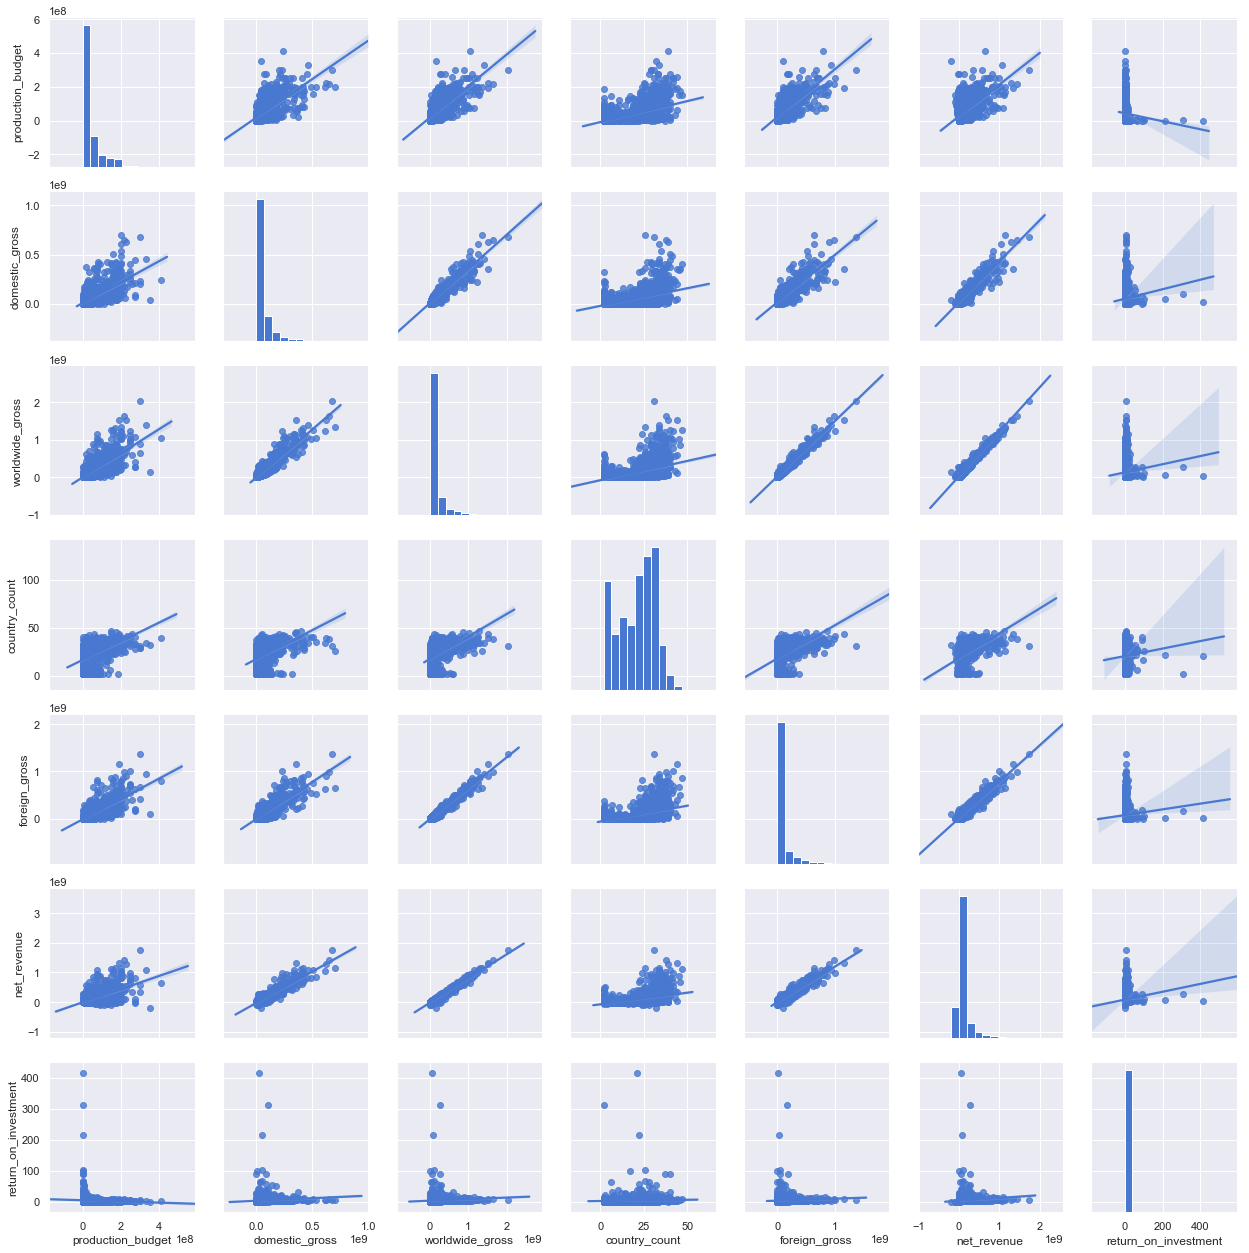

In [108]:
sns.set(context='notebook', style='darkgrid', color_codes=True, palette='muted')

sns.pairplot(df_int_movies_analysis_inner, kind='reg');

**This is great! On our first look we can already see that a positive relationship exists between 'country_count' and our gross figures. Though remember, our question is interested in profitability, not just revenue. The last column on the above matrix shows a very wide range of potential profitability, however the direction that is it going is great! We also observe that there are A LOT of positively-skewed features for budget and revenue distributions.**

**Next, let's take a closer look at our individual features using a boxplot to help us better contextualize the outliers.** 

## Boxplot - Outlier Identification

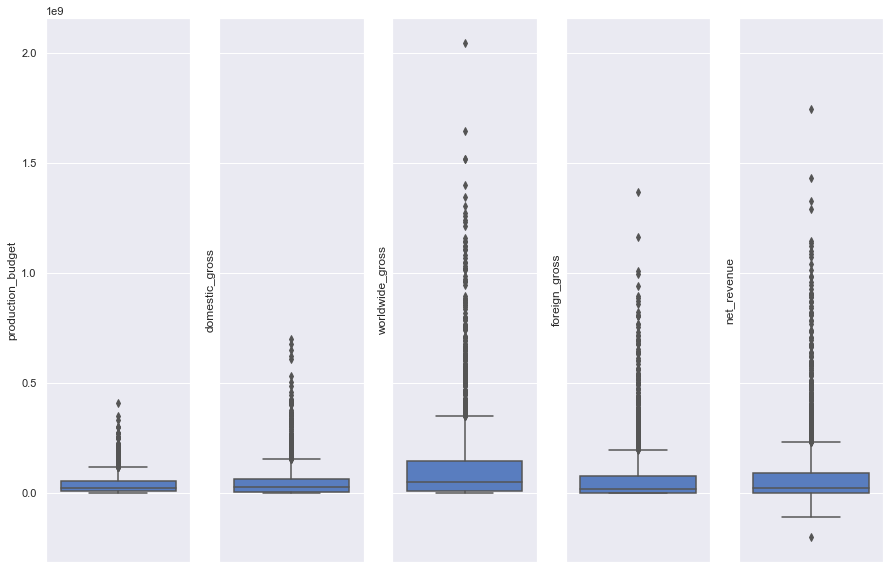

In [109]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(15,10), sharey=True)

ax_list = [ax1, ax2, ax3, ax4, ax5]
x = [df_int_movies_analysis_inner['production_budget'],
     df_int_movies_analysis_inner['domestic_gross'],
     df_int_movies_analysis_inner['worldwide_gross'],
     df_int_movies_analysis_inner['foreign_gross'],
     df_int_movies_analysis_inner['net_revenue']]


for n in range(1,6):
    ax = ax_list[n-1]
    x_new = x[n-1]
    sns.set_style('darkgrid')
    sns.boxplot(x_new, ax=ax, orient='v')

**Whoa! Looks like the data here are littered with outliers on the positive end of the spectrum.  Let's try a few different techniques and see which ones result in a more normalized distribution!**

## Outlier Exploration & Visualizations

**Let's create a new dataframe to use for the following EDA purposes since we have so many outliers in our original dataset.**

In [110]:
df_int_movies_analysis_inner_cleaned = df_int_movies_analysis_inner.copy()
print(df_int_movies_analysis_inner_cleaned.shape)
df_int_movies_analysis_inner_cleaned.head()

(1760, 12)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,net_revenue,return_on_investment,profit/loss,country_count_category
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39,8.046000e+08,6.350639e+08,1.546673,profit,31 - 40
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",32,1.070000e+08,-2.002376e+08,-0.572108,loss,31 - 40
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34,9.440081e+08,1.072414e+09,3.243841,profit,31 - 40
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31,1.369319e+09,1.748134e+09,5.827114,profit,31 - 40
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29,4.269209e+08,3.559452e+08,1.186484,profit,21 - 30


**The feature that looks like it contains the most egregious amount of outliers is 'worldwide_gross'. Let's see how the data are affected when we start to preform some outlier cleaning in the cell below.  Let's write a function in the following cell that will take in information about how we want to adjust our dataframe using quantiles. This function will allow us to perform quick EDA, and if we see something that we like, we can just re-define a new dataframe as needed.**

##  Function - Quantile Column Cleaning

In [111]:
def between_quantile_col_cleaner(df, colname, lower_quantile, upper_quantile):
    
    '''This function\'s purpose is to address outliers in data.  This funciton
    takes in a dataframe, column name, and both lower/upper quantiles to keep
    data using the .between method.
    
    Returns:
    Dataframe
    
    Example:
    between_quantile_cleaner(df_cars, 'type', 0.05, 0.95)'''
    
    column_total = df[colname]
    
    column_remaining = column_total.between(
        column_total.quantile
        (
            lower_quantile
        ),
        column_total.quantile
        (
            upper_quantile
        ))
    df = df.iloc[column_remaining[column_remaining].index]
    print(df.shape)
    return df

between_quantile_col_cleaner(df_int_movies_analysis_inner_cleaned, 'worldwide_gross', .10, .90)

(1408, 12)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,net_revenue,return_on_investment,profit/loss,country_count_category
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,149762350.0,"[France, Mexico, Italy, Poland, Hungary, Portu...",32,107000000.0,-200237650.0,-0.572108,loss,31 - 40
8,2013-07-02,The Lone Ranger,275000000.0,89302115.0,260002115.0,"[Italy, Ukraine, Slovakia, Venezuela, Bolivari...",33,170700000.0,-14997885.0,-0.054538,loss,31 - 40
9,2012-03-09,John Carter,275000000.0,73058679.0,282778100.0,"[Ukraine, United States, Argentina, India, Lit...",28,209719421.0,7778100.0,0.028284,profit,21 - 30
19,1998-08-14,The Avengers,60000000.0,23385416.0,48585416.0,"[Peru, Turkey, Mexico, Slovakia, Colombia, Swe...",39,25200000.0,-11414584.0,-0.190243,loss,31 - 40
22,2012-05-18,Battleship,220000000.0,65233400.0,313477717.0,"[Uruguay, Greece, Viet Nam, Lithuania, Colombi...",25,248244317.0,93477717.0,0.424899,profit,21 - 30
27,2010-05-14,Robin Hood,210000000.0,105487148.0,322459006.0,"[Russian Federation, Serbia, Greece, Turkey, F...",30,216971858.0,112459006.0,0.535519,profit,21 - 30
28,2018-11-21,Robin Hood,99000000.0,30824628.0,84747441.0,"[Russian Federation, Serbia, Greece, Turkey, F...",30,53922813.0,-14252559.0,-0.143965,loss,21 - 30
43,2011-06-17,Green Lantern,200000000.0,116601172.0,219535492.0,"[Slovenia, Peru, Korea, Republic of, Turkey, U...",24,102934320.0,19535492.0,0.097677,profit,21 - 30
47,2013-03-01,Jack the Giant Slayer,195000000.0,65187603.0,197687603.0,"[France, Israel, Bolivia, Plurinational State ...",32,132500000.0,2687603.0,0.013783,profit,31 - 40
51,2013-05-10,The Great Gatsby,190000000.0,144840419.0,351040419.0,"[Germany, Czechia, Slovenia, United States, Ve...",36,206200000.0,161040419.0,0.847581,profit,31 - 40


## Funtion - Quantile Column Cleaning (Removed Rows)

**Here is a function that shows us the movies that were dropped.  This is a useful function as it allows us to see which movies don't make the cleaning-cut!**

In [112]:
def between_quantile_col_removed(df, colname, lower_quantile, upper_quantile):
    
    '''This function\'s purpose is to address outliers in data.  This funciton
    takes in a dataframe, column name, and both lower/upper quantiles to keep
    data using the .between method.
    
    Returns:
    Dataframe
    
    Example:
    between_quantile_cleaner(df_cars, 'type', 0.05, 0.95)'''
    
    column_total = df[colname]
    
    column_remaining = column_total.between(
        column_total.quantile
        (
            lower_quantile
        ),
        column_total.quantile
        (
            upper_quantile
        ))
    df = df.drop(column_remaining[column_remaining].index)
    print(df.shape)
    return df

between_quantile_col_removed(df_int_movies_analysis_inner_cleaned, 'worldwide_gross', .10, .90)

(352, 12)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,net_revenue,return_on_investment,profit/loss,country_count_category
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39,8.046000e+08,6.350639e+08,1.546673,profit,31 - 40
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34,9.440081e+08,1.072414e+09,3.243841,profit,31 - 40
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31,1.369319e+09,1.748134e+09,5.827114,profit,31 - 40
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29,4.269209e+08,3.559452e+08,1.186484,profit,21 - 30
5,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,"[Bulgaria, Portugal, Serbia, Russian Federatio...",29,6.795467e+08,5.796209e+08,1.932070,profit,21 - 30
6,2012-07-20,The Dark Knight Rises,275000000.0,448139099.0,1.084439e+09,"[Slovenia, Lithuania, Uruguay, Japan, United S...",40,6.363000e+08,8.094391e+08,2.943415,profit,31 - 40
7,2018-05-25,Solo: A Star Wars Story,275000000.0,213767512.0,3.931513e+08,"[Sweden, Serbia, Hungary, Lithuania, Romania, ...",33,1.793838e+08,1.181513e+08,0.429641,profit,31 - 40
10,2010-11-24,Tangled,260000000.0,200821936.0,5.864772e+08,"[France, Lithuania, Sweden, Bulgaria, Ukraine,...",44,3.856553e+08,3.264772e+08,1.255682,profit,41 +
11,2016-05-06,Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,"[United States, Turkey, Czechia, Chile, Mexico...",33,7.319851e+08,8.900694e+08,3.560278,profit,31 - 40
12,2016-03-25,Batman v Superman: Dawn of Justice,250000000.0,330360194.0,8.675003e+08,"[Croatia, Mexico, Romania, Israel, Canada, Bul...",31,5.371401e+08,6.175003e+08,2.470001,profit,31 - 40


## Boxplot - Box Office Numbers w/ Outlier Manipulation

 **Ok, let's have a look at our data now using our new function and see how the below plots change. The data between the 10th and 90th percentile looks the most reasonable for this visualization.**

(1408, 12)


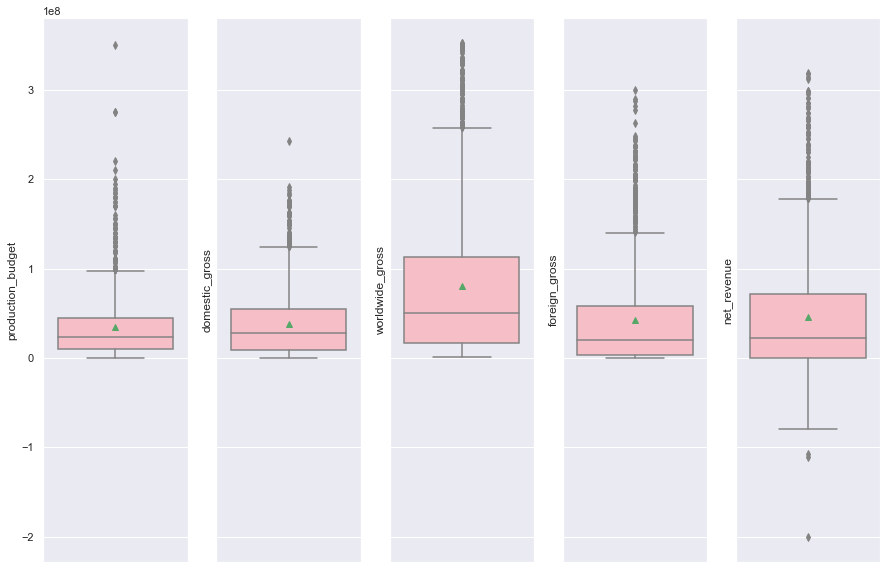

In [132]:
df_int_movies_analysis_inner_cleaned_boxtest = between_quantile_col_cleaner(
    df_int_movies_analysis_inner_cleaned,
    'worldwide_gross',
    .10,
    .90)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize=(15,10))

ax_list = [ax1, ax2, ax3, ax4, ax5]
x = [df_int_movies_analysis_inner_cleaned_boxtest['production_budget'],
     df_int_movies_analysis_inner_cleaned_boxtest['domestic_gross'],
     df_int_movies_analysis_inner_cleaned_boxtest['worldwide_gross'],
     df_int_movies_analysis_inner_cleaned_boxtest['foreign_gross'],
     df_int_movies_analysis_inner_cleaned_boxtest['net_revenue']]

for n in range(1,6):
    ax = ax_list[n-1]
    x_new = x[n-1]
    sns.set_style('darkgrid');
    sns.boxplot(x_new, ax=ax, orient='v', showmeans=True, color='lightpink');

## Countplot - Countries Per Movie w/ Outlier Manipulation

**Now lets do the same testing but with a countplot.  This visual looks quite similar regardless of the manner with which it was sliced.  Therefore the full dataset was chosen for the best representation of this visual.**

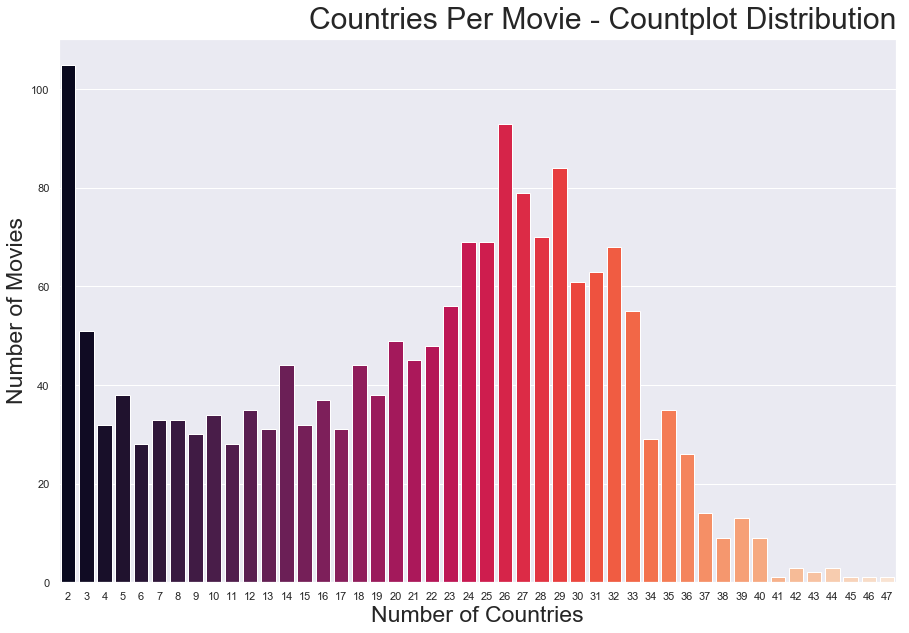

In [127]:
df_int_movies_analysis_inner_cleaned_histtest = df_int_movies_analysis_inner_cleaned

# between_quantile_col_cleaner(
#     df_int_movies_analysis_inner_cleaned,
#     'worldwide_gross',
#     .10,
#     .90)

plt.figure(figsize=(15,10))

column = df_int_movies_analysis_inner_cleaned_histtest['country_count']

sns.countplot(x=column,
              data=df_int_movies_analysis_inner_cleaned_histtest,
              saturation=2,
              palette="rocket");

plt.ylabel('Number of Movies', fontsize=23)
plt.xlabel('Number of Countries', fontsize=23)
plt.title('Countries Per Movie - Countplot Distribution', fontsize=30, pad=10, loc='right');

# Microsoft Question Visualization & Conclusion

**Okay, now for the last step.  We have seen above how the data can change depending on how we treat our outliers.  Let's now aim to answer the big question:**

**Are movies that are released in more countries more profitable?**

**Let's create two more plots and put them side by side.  The firs plot will look at the costs of producing these movies, as well as how much money the tend to bring back in.  The second plot will look at the number of movies that come out of the international scene with either a profit or a loss.  The following plots will use the MEDIAN as its estimator fucntion as it is the best tool we have to combat against the many outliers that remain.**

**These last two visualizations will be shown using the data from the 1st to 99th percentile. There were some variations in the plotting depending on how the dataset was sliced, but the reasons were mostly due to not having a large sample size of movies in over 40 coutnries.  Therefore we chose to stick with the subset below in the end.**

(1724, 12)


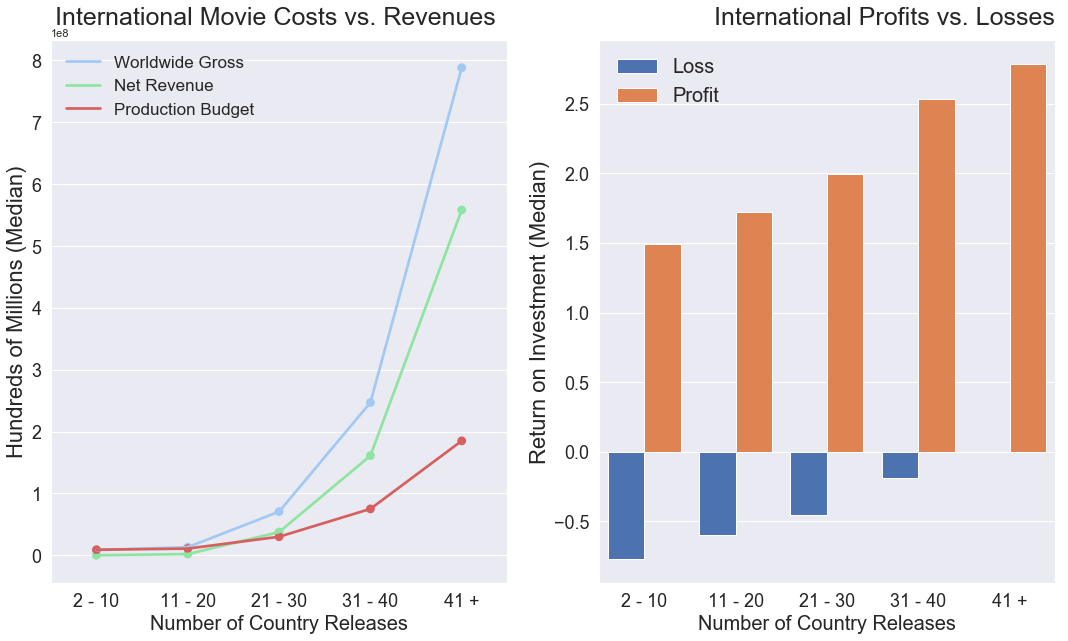

In [137]:
df_int_movies_analysis_inner_cleaned_bartest = between_quantile_col_cleaner(
    df_int_movies_analysis_inner_cleaned,
    'worldwide_gross',
    .01,
    .99)

fig = plt.figure(figsize=(18,10));
sns.set(style='darkgrid');
order = ['2 - 10', '11 - 20', '21 - 30', '31 - 40', '41 +']
#  - 50', '51 - 60', '61 +'

ax1 = fig.add_subplot(121)

sns.set_color_codes('pastel')
sns.pointplot(x='country_count_category',
            y='worldwide_gross',
            data=df_int_movies_analysis_inner_cleaned_bartest,
            color='b',
            order=order,
            estimator=np.median,
            ax=ax1,
            ci=None);

sns.set_color_codes('pastel')
sns.pointplot(x='country_count_category',
            y='net_revenue',
            data=df_int_movies_analysis_inner_cleaned_bartest,
            color='g',
            order=order,
            estimator=np.median,
            ax=ax1,
            ci=None);

sns.set_color_codes('muted')
sns.pointplot(x='country_count_category',
            y='production_budget',
            data=df_int_movies_analysis_inner_cleaned_bartest,
            color='r',
            order=order,
            estimator=np.median,
            ax=ax1,
            ci=None);

plt.title('International Movie Costs vs. Revenues ', fontsize=25, loc='center', pad=15);
plt.legend(['Worldwide Gross', 'Net Revenue', 'Production Budget'], frameon=False, fontsize=17, loc='upper left');
plt.ylabel('Hundreds of Millions (Median)', fontsize=22);
plt.xlabel('Number of Country Releases', fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

ax2 = fig.add_subplot(122)

# sns.set_color_codes('pastel')
# sns.barplot(x='country_count_category',
#             y='foreign_gross',
#             data=df_int_movies_analysis_inner_cleaned_bartest,
#             color='orange',
#             order=order,
#             estimator=np.median,
#             ax=ax2,
#             ci=None);

sns.barplot(x='country_count_category',
            y='return_on_investment',
            data=df_int_movies_analysis_inner_cleaned_bartest,
            order=order,
            estimator=np.median,
            ax=ax2,
            ci=None,
            saturation=20,
            hue='profit/loss',
            hue_order=['loss', 'profit']);

# sns.set_color_codes('pastel')
# sns.pointplot(x='country_count_category',
#             y='net_revenue',
#             data=df_int_movies_analysis_inner_cleaned_bartest,
#             color='darkgreen',
#             order=order,
#             estimator=np.median,
#             ax=ax2,
#             ci=None);

plt.title('International Profits vs. Losses', fontsize=25, loc='right', pad=15);
plt.legend(['Loss', 'Profit'], frameon=False, fontsize=20, loc='upper left');
plt.ylabel('Return on Investment (Median)', fontsize=22);
plt.xlabel('Number of Country Releases', fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

# Observation Conclusions
**These last two visualizations paint the picture quite clearly that in fact yes, movies that are released in more countries are generally more profitable.  We can also make some conclusions about the risks involved in making movies that are meant to be for a global audience.**

# Future Work Recommendations
**- To take this analysis further, it would have been great to see more accurate information for country counts per movie. If we had a better picture about not just which countries, but the timing of the release in each subsequent country, then a lot of work could be done in determining the best time to release and where.**

**- Additionally, more detailed information about the distribution of the revenue between each country would have been very insightful.  This could have led to observations surrounding each country and their consumption patterns and preferences.**

# * * Bonus * * - "Domestic" Movie Country Count Estimator

**As we can see below, the IMDB database was not as accurate as we would have liked.  Avatar is still the largest movie ever made in almost all aspects, yet it has a country list consisting only of Japan.  We thought it would be interesting to see, based on the cleaning of the previous data, if we could predict the number of movies that a country was released in based on its financial metrics.  Below we have made a function to check against the 'worldwide_gross' value, though this function could easily be altered to measure against any of the numerical features.**

In [116]:
df_domestic_country_check = df_movie_moneys.merge(df_domestic_title_country, on='primary_title')

df_domestic_country_check = df_domestic_country_check.sort_values('worldwide_gross', ascending=False)

df_domestic_country_check['return_on_investment'] = (
    (df_domestic_country_check['worldwide_gross'] - 
     df_domestic_country_check['production_budget']) / 
    df_domestic_country_check['production_budget'])

df_domestic_country_check['profit/loss'] = df_domestic_country_check[
    'return_on_investment'].map(lambda x: profit_loss_function(x))

df_domestic_country_check['foreign_gross'] = df_domestic_country_check[
    'worldwide_gross'] - df_domestic_country_check['domestic_gross']

df_int_movies_analysis_inner['net_revenue'] = df_int_movies_analysis_inner[
    'worldwide_gross'] - df_int_movies_analysis_inner['production_budget']

df_domestic_country_check.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,movies_per_country,return_on_investment,profit/loss,foreign_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,Japan,1,5.532577,profit,2.015838e+09
1,1997-12-19,Titanic,200000000.0,659363944.0,2.208208e+09,United Kingdom,1,10.041042,profit,1.548844e+09
7,2009-12-25,Sherlock Holmes,90000000.0,209028679.0,4.984382e+08,United States,1,4.538202,profit,2.894095e+08
5,2000-05-05,Gladiator,103000000.0,187683805.0,4.576838e+08,Australia,1,3.443532,profit,2.700000e+08
8,2000-12-22,Cast Away,85000000.0,233632142.0,4.272305e+08,Puerto Rico,1,4.026241,profit,1.935984e+08


In [117]:
df_int_movies_analysis_inner_cleaned.groupby('country_count_category').median()

,production_budget,domestic_gross,worldwide_gross,country_count,foreign_gross,net_revenue,return_on_investment
country_count_category,,,,,,,
11 - 20,10600000.0,7710234.0,13019253.0,16.0,2828779.0,1927779.0,0.209835
2 - 10,8000000.0,4829804.0,7263222.0,5.0,98053.0,-204.5,-0.001842
21 - 30,30000000.0,35599744.5,70671126.0,26.0,31200720.0,38215892.0,1.433405
31 - 40,75000000.0,89302115.0,260002115.0,33.0,154599082.0,167023808.0,2.594978
41 +,187500000.0,246200985.0,899906806.5,43.5,575300946.5,687406806.5,3.799302


**The function below is based on the above table, replace the values as needed to switch between features to compare.**

In [119]:
def domestic_movie_guess(movie):
    
    '''This function takes in the name of a movie (string) from the 
    df_domestic_country_check dataset and returns an estimate of the number of
    countries that the movie was released in.'''
    
    dom_df = df_domestic_country_check
    int_df = df_int_movies_analysis_inner_cleaned
    
    country_prob_list = df_int_movies_analysis_inner_cleaned.groupby('country_count_category').median()['worldwide_gross']
#     print(country_prob_list)
    
    country_prob_list_keys = list(country_prob_list.keys())
#     print(country_prob_list_keys)
    
    country_prob_list_values = list(country_prob_list.unique())
#     print(country_prob_list_values)
    
    prob_dict = {}
    
#     for i in country_prob_list_values:
#         prob_dict[i] = country_prob_list_values[i]
    prob_dict['7263222.0'] = '10 or less'
    prob_dict['13019253.0'] = '11 - 20'
    prob_dict['70671126.0'] = '21 - 30'
    prob_dict['260002115.0'] = '31 - 40'
    prob_dict['899906806.5'] = '41 +'
#     print(prob_dict)
    
    worldwide_gross = int(dom_df[dom_df['primary_title'] == movie]['worldwide_gross'].unique())
#     print(worldwide_gross)

    for i in country_prob_list_values:
        n = 0
        if worldwide_gross > country_prob_list_values[-1]:
            return country_prob_list_keys[-1]
        elif i < worldwide_gross:
#             print('passed')
            continue
        else:
            return print('Hmmmm, I\'m thinking this movie was released in {} countries.'.format(prob_dict[str(i)]))
        
    
domestic_movie_guess('Cast Away')

Hmmmm, I'm thinking this movie was released in 41 + countries.


**Feel free to check out your favourite  movie source online to compare the results!** 